# **Diplomado IA: Audio y Video - Parte 1**. <br> Práctico 3: Redes Convolucionales y Modelos Preentrenados
---
---

**Profesores:**
- Alain Raymond
- Gabriel Sepúlveda
- Álvaro Soto

**Ayudante:**
- Gabriel Molina
---
---

El siguiente práctico se debe realizar de forma individual. El formato de entregar es el **archivo .ipynb con todas las celdas ejecutadas**. Las secciones donde se planteen preguntas de forma explícita, deben ser respondida en celdas de texto, y no se aceptará solo el _output_ de una celda de código como respuesta.

**Nombre alumno:** FRANCISCO MENA

El siguiente práctico cuanta con 3 secciones donde cada una contendrá 1 o más actividades a realizar. Algunas actividades corresponderán a escribir código y otras a responder preguntas. 

Antes de responder, se recomienda **fuertemente** revisar las secciones previas donde se desarrollan los ejemplos, dado que algunas de las actividades pueden ser completadas reutilizando el mismo código.

**Fecha de entrega:** viernes 14 de mayo de 2021, 23:59 hrs.

---
**IMPORTANTE:** habrá un bonus de 1 décima para todos aquellos alumnos/as que muestren buen orden en sus respuestas (esto aplica a legibilidad de código, buena redacción, formalidad, organización del jupyter notebook, seguimiento de instrucciones, etc). El criterio lo pondrá cada ayudante corrector. La nota máxima obtenible en el laboratorio es 7.0

### Préambulo

Instalamos las herramientas que necesitamos:

In [7]:
!pip install torchaudio==0.7.0 -q   # Para todo el práctico
!pip install soundfile -q           # Para la parte 2

     |████████████████████████████████| 7.6MB 4.2MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.


**Importante:** una vez instaladas las librerías resetear el ambiente! Si no, les dará un error.

## Parte 1: Conociendo la familia de redes M.

En esta primera parte del laboratorio conoceremos la familia de redes M (M3, M5, M11, M18 y M34_RES) y las utilizaremos para resolver un problema previo que encontramos: el dataset UrbanSound8k. Esta vez, eso sí, en vez de trabajar con los features MFCC, trabajaremos directamente con la señal de audio original. ¿Funcionará bien esto? ¡Veamos!

Paper: https://arxiv.org/pdf/1610.00087.pdf

Código adaptado de: https://github.com/engmubarak48/Very_Deep_CNN_AudioClassification



#### Red M5: Diagrama

* Primera capa hace un *downsampling* importante, primero usando un *kernel* de 80, luego con un *stride* de 4 y finalmente con un Max Pooling de *stride* 4. Reduce el tamaño de entrada en un factor de 16 aproximadamente.
* No hay padding.
* Aparte de la primera capa, todas usan *kernels* de tamaño 3.
* Max Pool es siempre de *kernel* 4 y *stride* 4.
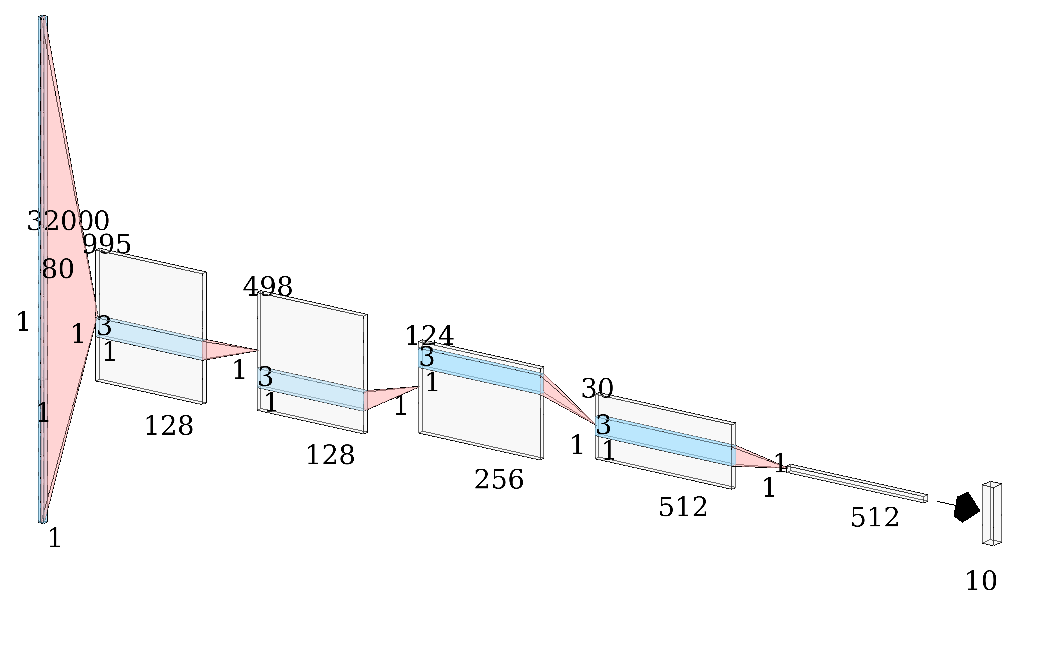

*Diagrama creado con:* http://alexlenail.me/NN-SVG

## Modelos

In [1]:
import torch.nn as nn
import torch
class M3(nn.Module):
    def __init__(self):
        super(M3, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, 80, 4)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(256, 256, 3)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(498)
        self.fc1 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.avgPool(x)
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x


class M5(nn.Module):
    def __init__(self):
        super(M5, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)   # (1, 32000) --> (128, 7981)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)            # (128, 7981) --> (128, 1995)
        self.conv2 = nn.Conv1d(128, 128, 3)     # (128, 1995) --> (128, 1993)
        self.bn2 = nn.BatchNorm1d(128)  
        self.pool2 = nn.MaxPool1d(4)            # (128, 1993) --> (128, 498)
        self.conv3 = nn.Conv1d(128, 256, 3)     # (128, 498) --> (256, 496)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)            # (256, 496) --> (256, 124)
        self.conv4 = nn.Conv1d(256, 512, 3)     # (256, 124) --> (512, 122)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)            # (512, 122) --> (512, 30)
        self.avgPool = nn.AvgPool1d(30)         # (512, 30) --> (512, 1)
        self.fc1 = nn.Linear(512, 10)           # (512 -->  10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return x

# M11
class M11(nn.Module):
    def __init__(self):
        super(M11, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(64, 64, 3) 
        self.conv21 = nn.Conv1d(64, 64, 3) 
        self.bn2 = nn.BatchNorm1d(64)
        self.bn21 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.conv31 = nn.Conv1d(128, 128, 3)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn31 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(128, 256, 3)
        self.conv41 = nn.Conv1d(256, 256, 3)
        self.conv42 = nn.Conv1d(256, 256, 3)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn41 = nn.BatchNorm1d(256)
        self.bn42 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(4)
        
        self.conv5 = nn.Conv1d(256, 512, 3)
        self.conv51 = nn.Conv1d(512, 512, 3)
        self.bn5 = nn.BatchNorm1d(512)
        self.bn51 = nn.BatchNorm1d(512)

        self.avgPool = nn.AvgPool1d(25)
        self.fc1 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn21(self.conv21(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn31(self.conv31(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn41(self.conv41(x)))
        x = F.relu(self.bn42(self.conv42(x)))
        x = self.pool4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn51(self.conv51(x)))
        x = self.avgPool(x)
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

class M18(nn.Module):
    def __init__(self):
        super(M18, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(64, 64, 3) 
        self.conv21 = nn.Conv1d(64, 64, 3)
        self.conv22 = nn.Conv1d(64, 64, 3)
        self.conv23 = nn.Conv1d(64, 64, 3)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn21 = nn.BatchNorm1d(64)
        self.bn22 = nn.BatchNorm1d(64)
        self.bn23 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.conv31 = nn.Conv1d(128, 128, 3)
        self.conv32 = nn.Conv1d(128, 128, 3)
        self.conv33 = nn.Conv1d(128, 128, 3)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn31 = nn.BatchNorm1d(128)
        self.bn32 = nn.BatchNorm1d(128)
        self.bn33 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(128, 256, 3)
        self.conv41 = nn.Conv1d(256, 256, 3)
        self.conv42 = nn.Conv1d(256, 256, 3)
        self.conv43 = nn.Conv1d(256, 256, 3)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn41 = nn.BatchNorm1d(256)
        self.bn42 = nn.BatchNorm1d(256)
        self.bn43 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(4)
        
        self.conv5 = nn.Conv1d(256, 512, 3)
        self.conv51 = nn.Conv1d(512, 512, 3)
        self.conv52 = nn.Conv1d(512, 512, 3)
        self.conv53 = nn.Conv1d(512, 512, 3)
        self.bn5 = nn.BatchNorm1d(512)
        self.bn51 = nn.BatchNorm1d(512)
        self.bn52 = nn.BatchNorm1d(512)
        self.bn53 = nn.BatchNorm1d(512)
        
        self.avgPool = nn.AvgPool1d(20)
        self.fc1 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn21(self.conv21(x)))
        x = F.relu(self.bn22(self.conv22(x)))
        x = F.relu(self.bn23(self.conv23(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn31(self.conv31(x)))
        x = F.relu(self.bn32(self.conv32(x)))
        x = F.relu(self.bn33(self.conv33(x)))
        x = self.pool3(x)
        
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn41(self.conv41(x)))
        x = F.relu(self.bn42(self.conv42(x)))
        x = F.relu(self.bn43(self.conv43(x)))
        x = self.pool4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn51(self.conv51(x)))
        x = F.relu(self.bn52(self.conv52(x)))
        x = F.relu(self.bn53(self.conv53(x)))
        x = self.avgPool(x)
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

Alguos comentarios sobre las decisiones de diseño de este modelo:

* En general se ocupan *kernels* pequeños de tamaño 3 en las convoluciones, *excepto* en la primera capa. En ésta se toma un *kernel* de 80. Esto es para reflejar alrededor de 10ms de audio, que es un largo de tiempo estándar usado en otras aplicaciones que ocupan MFCC. Los autores mencionan que lo aprendido por esta primera capa es similar a un filtro pasabandas, es decir, la primera capa aprende a dejar pasar ciertas frecuencias y omitir otras.

* Respecto al resto, vemos un patrón usual con modelos convolucionales de imágenes: una reducción progresiva de la resolución espacial, junto con un aumento progresivo de la cantidad de canales.
* ¿Por qué AvgPool al final? Según autores del paper, esto es para reemplazar las capas Fully Connected usuales y forzar a la parte convolucional a generar buenas representaciones. Observan que un modelo Fully Convolutional anda igual o mejor que usando capas FC.

## Manejando los datos

Esta vez trabajaremos con el formato oficial del Dataset UrbanSound8K. Esto quiere decir, que en vez de tener un split de train, validación y test, ocuparemos los 10 *folds* originales que vienen en el dataset.

### Un ligero desvío: K-Fold Cross Validation

Si recuerdan de su primer laboratorio, entrenamos un MLP sencillo con este mismo dataset que tuvo resultados de más de 90% en el set de test.

Sin embargo, este resultado es poco fiable por una regla básica que fue violada al entrenar ese modelo en ese momento: *el set de entrenamiento no debe estar correlacionado al set de test*. En ese momento, esto no era importante pues nuestro objetivo era entender el audio más que entrenar modelos. Esto lo arreglaremos esta vez. UrbanSound8K cuenta con varios subdatasets que llamaremos *folds*. Con estos *folds* podremos ejecutar una técnica que se llama *K-Fold Cross Validation*, que en palabras simples nos dice:

* Vamos a entrenar K versiones de nuestro modelo.
* Cada una de estas versiones será entrenada con K-1 folds y testeada en el fold restante.
* En el caso de este dataset K=10.

**¿Por qué esta forma tan extraña de probar?**

Porque nos da una idea mejor de cómo generaliza nuestro modelo. Si no hiciésemos esto, podríamos tener la mala suerte de que elegimos un test de prueba fácil o correlacionado y sobreestimamos la capacidad de nuestro algoritmo.

Esta vez, entrenaremos con un fold específico de prueba que sabemos no está correlacionado con el set de entrenamiento. De esta manera deberíamos tener una idea más real del rendimiento de nuestro modelo.

**¿Debería ocupar K-Fold Cross Validation siempre? ¡Suena costoso!**

En general, K-Fold Cross Validation se ocupa sólo cuando tenemos pocos datos. Si tenemos muchos datos (que suele pasar en Deep Learning), es más probable que nuestro set de test sea representativo de la distribución de los datos.

**Tengo K versiones de mi modelo, ¿con cuál me quedo?** 

Con ninguna. Usamos Cross Validation para entender el potencial rendimiento de nuestros modelos, pero en la práctica al final ocuparemos todos nuestros datos para entrenar la versión final modelo que queramos usar.

### Descargando el dataset (10 minutos aprox)

Sugiero descargar el dataset y guardarlo en su carpeta de Drive, para no tener que descargarlo cada vez.



In [2]:
!wget https://goo.gl/8hY5ER -O UrbanSound8k.tar.gz -q --show-progress # Descarga del dataset
!tar -xzf UrbanSound8k.tar.gz           # Descomprimimos el dataset

UrbanSound8k.tar.gz 100%[===================>]   5.61G  28.8MB/s    in 5m 5s   


In [3]:
!tar -xzf  /content/drive/MyDrive/Diplomados/Audio/UrbanSound8k.tar.gz #Esto solo se corre si ya tienen guardado en alguna ruta el dataset

tar (child): /content/drive/MyDrive/Diplomados/Audio/UrbanSound8k.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


### Clase Dataset

En este caso, nuestra clase dataset tomará como parámetros no sólo las rutas donde están nuestros datos, sino también qué folds queremos que sean incluidos en nuestro dataset. Esto es útil para generar los datasets de entrenamiento y test correctos. Aparte de esto, nuestra clase leerá archivos de audio con $\texttt{torchaudio.load}$ y los dejará de un tamaño fijo

In [4]:
import os
import glob             # Librería para recorrer los directorios de nuestro computador
import numpy as np
import pandas as pd     # Para leer el CSV con la metadata del dataset (i.e. labels)
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Esta sesión correrá ocupando como dispositivo de entrenamiento: {}".format(device))


class AudioDataset(Dataset):
    """
    A wrapper class for the UrbanSound8K dataset.
    """

    def __init__(self, file_path, audio_paths, folds):
        """
        Args:
            file_path(string): path to the audio csv file
            root_dir(string): directory with all the audio folds
            folds: integer corresponding to audio fold number or list of fold number if more than one fold is needed
        """
        self.audio_file = pd.read_csv(file_path)
        self.folds = folds
        self.audio_paths = glob.glob(audio_paths + '/*' + str(self.folds) + '/*')
    

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        
        audio_path = self.audio_paths[idx]
        audio, rate = torchaudio.load(audio_path, normalization=True)
        audio = audio.mean(0, keepdim=True) # Convertimos a Monaural (1-canal)
        c, n = audio.shape
        zero_need = 160000 - n
        audio_new = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0)
        audio_new = audio_new[:,::5]  # Sampleamos 1 de cada 5 muestras para reducir tamaño
        
        #Getting the corresponding label
        audio_name = audio_path.split(sep='/')[-1]
        labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
        
        return audio_new, labels



def init_weights(m):
    if type(m) == nn.Conv1d or type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight.data)



Esta sesión correrá ocupando como dispositivo de entrenamiento: cuda


/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Código de Entrenamiento

In [5]:
def train(model, epoch, log_interval=10):
    model.train()
    correct = 0
    losses_train = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        data = data.requires_grad_() #set requires_grad to True for training
        output = model(data)
        output = output.permute(1, 0, 2) #original output dimensions are batchSizex1x10 
        loss = criterion(output[0], target) #the loss functions expects a batchSizex10 input
        losses_train.append(loss.item())
        pred = output.max(2)[1] 
        correct += pred.eq(target).cpu().sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0: #print training stats
            print('\rEpoca Entrenamiento: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),  
                  100. * batch_idx / len(train_loader), loss), end="")
    print("")
    return 100. * correct / len(train_loader.dataset), np.mean(losses_train)

def test(model, epoch):
    model.eval()
    correct = 0
    test_losses = []
    test_p = []
    test_gts = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(data)
            output = output.permute(1, 0, 2)
            # Calculo métricas
            # Pérdida
            loss = criterion(output[0], target) #the loss functions expects a batchSizex10 input
            test_losses.append(loss.item())
            # Exactitud
            pred = output.max(2)[1]                         # Nos quedamos con el mayor valor del output
            test_p.append(pred)
            test_gts.append(target)
            correct += pred.eq(target).cpu().sum().item()   # Sumamos los ejemplos en que le apuntamos a la clase
        test_p = torch.cat([x.squeeze() for x in test_p], dim=0).long()
        test_gts = torch.cat(test_gts, dim=0).long()
    return 100. * correct / len(test_loader.dataset), np.mean(test_losses), test_p, test_gts

### Gráfico de Métricas

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_results(ax, m_train, m_test, label_metrica="Perdida"):
    n_epocas = len(m_train)
    ax.plot(np.arange(n_epocas), m_train, label = 'Train')
    ax.plot(np.arange(n_epocas), m_test, label = 'Test')
    ax.set_title('{} durante Entrenamiento'.format(label_metrica))
    ax.set_xlabel('Épocas')
    ax.set_ylabel(label_metrica)
    ax.legend()
    return ax


# Función tomada de: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Verdadero')
        plt.xlabel('Predicho' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Reproducibilidad: ¡Otro ligero desvío!

Dada la naturaleza aleatoria del entrenamiento, tenderá a suceder que entrenar el mismo modelo, con los mismos datos, entregue resultados distintos. Esto tiene que ver con varios puntos:

* Aleatoriedad del orden en que entregamos los datos de entrada al modelo.
* Aleatoriedad de los pesos iniciales del modelo.
* Aleatoriedad intrínseca de operaciones de PyTorch.
* Aleatoriedad inducida por temas extra (Data Augmentation y Random Crops por ejemplo).

Por esto, a la hora de evaluar un modelo, si es posible, trataremos de mitigar esta aleatoriedad para tomar una decisión más informada. Hay dos cosas que podemos hacer:

* Entrenar varios modelos, promediar los resultados y obtener intervalos de confianza (Costoso, pero muy buena práctica).
* Desactivar las fuentes de aleatoriedad en nuestro código (Fácil).

El próximo bloque de código apaga las fuentes de aleatoriedad, fijando que el estado "aleatorio" antes de una corrida del código sea siempre igual, por lo que los eventos aleatorios que sucedan de ahí en adelante serán determinísticos.

In [7]:
import os
torch.manual_seed(0)                        # Seteamos las semilla aleatoria de PyTorch
torch.cuda.manual_seed(0)       
np.random.seed(0)                           # Lo mismo para Numpy
state_np = np.random.get_state()            # Obtenemos el estado aleatorio de Numpy para poder replicarlo después
state_torch = torch.random.get_rng_state()  # Obtenemos el estado aleatorio de PyTorch para poder replicarlo después
state_torch_cuda = torch.cuda.random.get_rng_state()
torch.set_deterministic(False)               # Hacemos que ciertas operaciones que PyTorch hace aleatorias sean determinísticas
torch.backends.cudnn.benchmark = False      # Otra fuente de aleatoriedad de PyTorch se apaga

### Loop de Entrenamiento

Epoca Entrenamiento: 0 [8640/8732 (99%)]	Loss: 1.570868
Epoca 1 Completa - Exactitud Train: 32.10% - Exactitud Test: 39.06%
Epoca Entrenamiento: 1 [8640/8732 (99%)]	Loss: 1.380438
Epoca 2 Completa - Exactitud Train: 40.17% - Exactitud Test: 37.11%
Epoca Entrenamiento: 2 [8640/8732 (99%)]	Loss: 1.496528
Epoca 3 Completa - Exactitud Train: 43.40% - Exactitud Test: 46.62%
Epoca Entrenamiento: 3 [8640/8732 (99%)]	Loss: 1.551625
Epoca 4 Completa - Exactitud Train: 45.65% - Exactitud Test: 48.22%
Epoca Entrenamiento: 4 [8640/8732 (99%)]	Loss: 1.356230
Epoca 5 Completa - Exactitud Train: 46.98% - Exactitud Test: 45.36%
Epoca Entrenamiento: 5 [8640/8732 (99%)]	Loss: 1.402345
Epoca 6 Completa - Exactitud Train: 47.38% - Exactitud Test: 38.60%
Epoca Entrenamiento: 6 [8640/8732 (99%)]	Loss: 1.525723
Epoca 7 Completa - Exactitud Train: 48.57% - Exactitud Test: 40.32%
Epoca Entrenamiento: 7 [8640/8732 (99%)]	Loss: 1.351069
Epoca 8 Completa - Exactitud Train: 48.97% - Exactitud Test: 41.12%
Epoca En

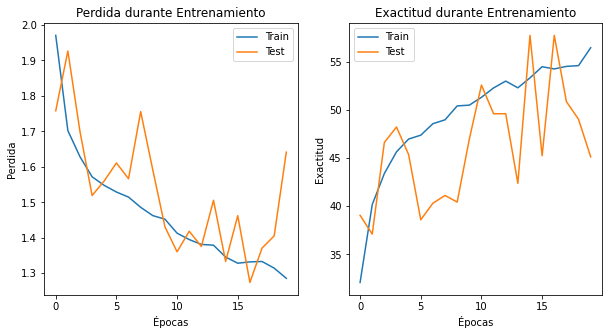

In [8]:
# Reproducibilidad: dejamos el estado de las semillas de aleatoriedad fijo
# en cada ejecución
torch.random.set_rng_state(state_torch)
torch.cuda.random.set_rng_state(state_torch_cuda)
np.random.set_state(state_np)
# Parametros para crear nuestros datasets a partir de los folds establecidos
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = './UrbanSound8K/audio/'
train_folds = [2,3,4,5,6,7,8,9,10]          # Entrenamos con folds 2-10
test_folds = [1]                            # Testeamos con el fold n°1
train_set = AudioDataset(csv_path, file_path, train_folds)
test_set = AudioDataset(csv_path, file_path, test_folds)
# Estos son parámetros para optimizar un poco la velocidad, no son críticos.
kwargs = {'num_workers': 0} if device == 'cuda' else {} 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, **kwargs)

# Creamos el modelo
net = M3()
#net = M18()           # Descomentar esta línea para entrenar con el modelo M18
net = net.to(device)
net.apply(init_weights) # Inicializamos los pesos de nuestra red con método Xavier

# Pérdida usual de Clasificación
criterion = nn.CrossEntropyLoss()
# Optimizador: Adam, no innovaremos.
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.0001)
# Opcional: el scheduler se encarga de cambiar el learning rate cada N épocas.
# Como está seteado ahora, el cambio sucede cada 20 épocas y multiplica 
# la tasa de aprendizaje por 0.1, es decir, la divide por 10.
# En la época 41 la reduciría de nuevo.
# Para las actividades que vamos a ocupar no importa, pero si desean entrenar
# por más épocas puede serles útil.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

# Métricas
# Guardamos la pérdida y la exactitud
loss_epoch_train = []
loss_epoch_test = []
accuracy_epoch_train = []
accuracy_epoch_test = []

# Loop de entrenamiento
n_epochs = 20
best_accuracy = 0.0
best_model = net

for epoch in range(n_epochs):
    accuracy_train, losses_train = train(net, epoch) # 1 época de entrenamiento
    scheduler.step() # Relacionado al Scheduler opcional, si se ocupa, se debe
                     # Hacer step después del fin de cada época
    loss_epoch_train.append(losses_train)         # Actualizamos métricas
    accuracy_epoch_train.append(accuracy_train)
    accuracy_test, losses_test, test_preds, test_gts = test(net, epoch) # Probamos en test cómo vamos
    loss_epoch_test.append(losses_test)           # Actualizamos métricas
    if accuracy_test > best_accuracy:             # Guardamos resultados del mejor modelo
        best_model = net
        best_accuracy = accuracy_test
        best_preds = test_preds
        best_gt = test_gts
    accuracy_epoch_test.append(accuracy_test)
    print('Epoca {} Completa - Exactitud Train: {:.2f}% - Exactitud Test: {:.2f}%'.format(epoch+1,accuracy_train, accuracy_test))

# Graficar resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = plot_results(ax[0],loss_epoch_train, loss_epoch_test, label_metrica="Perdida")
ax[1] = plot_results(ax[1],accuracy_epoch_train, accuracy_epoch_test, label_metrica="Exactitud")
fig.savefig('figure_fold:{0}_model:{1}.png'.format(1, "M3"))

### ¡Probemos el modelo!

In [9]:
clases = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jack_hammer','siren','street_music']

In [10]:
tensores, labels = next(iter(test_loader)) # Sacamos un batch de test
output = net(tensores.to(device))
output = output.permute(1, 0, 2)
preds = output.max(2)[1]
correct = preds.eq(labels.to(device))
preds = preds.squeeze()
correct = correct.squeeze()
elegidos = torch.nonzero(correct,as_tuple=True) # Indices de ejemplos correctos
no_elegidos = torch.nonzero(~correct,as_tuple=True)# Indices de ejemplos incorrectos
audios_correctos = tensores[elegidos]
labels_correctos = labels[elegidos]
audios_incorrectos = tensores[no_elegidos]
labels_incorrectos = labels[no_elegidos]
iterador_correctos = zip(audios_correctos, labels_correctos)
iterador_incorrectos = zip(audios_incorrectos, preds[no_elegidos], labels_incorrectos)

#### ¡Viendo los ejemplos correctos!

In [11]:
import IPython.display as ipd
audio, label = next(iterador_correctos)
print("Modelo predijo '{}' correctamente!".format(clases[label]))
ipd.Audio(audio, rate=16000)

Modelo predijo 'siren' correctamente!


#### ¡Viendo los ejemplos incorrectos!

In [12]:
audio, incorrecto, label = next(iterador_incorrectos)
print("Modelo predijo '{}' pero en verdad era '{}'!".format(clases[incorrecto], clases[label]))
ipd.Audio(audio, rate=16000)

Modelo predijo 'dog_bark' pero en verdad era 'siren'!


### Modelo Preentrenado por 50 épocas

Dado que esto puede tomar unas cuantas horas, veamos el resultado de uno de estos modelo entrenado por 50 épocas (con el mismo código) de arriba. Descarguémoslo:

In [13]:
!wget https://www.dropbox.com/s/ws38tacpjd38ocz/m3_50epochs.pth -q --show-progress # Bajamos los modelos preentrenados
!wget https://www.dropbox.com/s/m57bq7dop2m5cjk/m18_50epochs.pth -q --show-progress

m3_50epochs.pth     100%[===================>] 873.25K  --.-KB/s    in 0.006s  
m18_50epochs.pth    100%[===================>]  14.12M  --.-KB/s    in 0.07s   


#### Cargamos los pesos

In [14]:
pesos = torch.load("m3_50epochs.pth")
net = M3().to(device)
net.load_state_dict(pesos)
accuracy_test, losses_test, test_preds, test_gts = test(net, epoch) # Corremos por una epoca el modelo preentrenado

#### ¡Viendo los ejemplos correctos!

In [15]:
import IPython.display as ipd
audio, label = next(iterador_correctos)
print("Modelo predijo '{}' correctamente!".format(clases[label]))
ipd.Audio(audio, rate=16000)

Modelo predijo 'children_playing' correctamente!


#### ¡Viendo los ejemplos incorrectos!

In [16]:
audio, incorrecto, label = next(iterador_incorrectos)
print("Modelo predijo '{}' pero en verdad era '{}'!".format(clases[incorrecto], clases[label]))
ipd.Audio(audio, rate=16000)

Modelo predijo 'engine_idling' pero en verdad era 'air_conditioner'!


### Matriz de Confusión

Ahora veamos un poco el rendimiento más desagregado por clase. En particular miraremos la Matriz de Confusión y el *Precision* y *Recall* para cada clase. Éstas nos darán una visión más particular del rendimiento de nuestro modelo en cada clase, permitiéndonos entender sus fortalezas y debilidades.

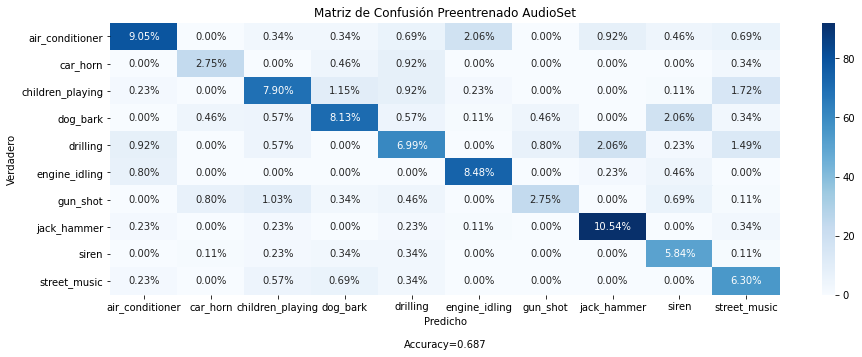

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
clases = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jack_hammer','siren','street_music']
cf = confusion_matrix(test_preds.cpu(), test_gts.cpu())
make_confusion_matrix(cf, categories=clases, count=False,figsize=(15,5),title="Matriz de Confusión Preentrenado AudioSet")

### Reporte Precision-Recall y F1

In [19]:
result = classification_report(test_gts.cpu(), test_preds.cpu(), labels=None, target_names=clases, digits=2, zero_division='warn')
print(result)

                  precision    recall  f1-score   support

 air_conditioner       0.62      0.79      0.70       100
        car_horn       0.62      0.67      0.64        36
children_playing       0.64      0.69      0.67       100
        dog_bark       0.64      0.71      0.67       100
        drilling       0.54      0.61      0.57       100
   engine_idling       0.85      0.77      0.81        96
        gun_shot       0.44      0.69      0.54        35
     jack_hammer       0.90      0.77      0.83       120
           siren       0.84      0.59      0.69        86
    street_music       0.77      0.55      0.64       100

        accuracy                           0.69       873
       macro avg       0.69      0.68      0.68       873
    weighted avg       0.71      0.69      0.69       873



### Actividad 1:

¿Qué cambios tendríamos que hacer necesariamente para entrenar con features MFCC en vez del audio puro como lo estamos haciendo acá? Puede haber más de una respuesta correcta.

* A - Resamplear el audio a otra Frecuencia de Muestreo
* B - Agregar una transformación MFCC a los datos
* C - Aumentar la cantidad de datos de entrada 
* D - Modificar la arquitectura del modelo 
* E - Ajustar la tasa de aprendizaje
* F - Cambiar la función de pérdida

In [ ]:
#@title Actividad 1
A = False #@param {type:"boolean"}
B = True #@param {type:"boolean"}
C  = False #@param {type:"boolean"}
D = False #@param {type:"boolean"}
E = False #@param {type:"boolean"}
F = False #@param {type:"boolean"}

### Actividad 2:

Usted entrena un modelo 2 veces y le da resultados distintos. ¿Por qué podría estar pasando esto?

* A - La arquitectura del modelo.
* B - PyTorch.
* C - La tasa de aprendizaje.
* D - La función de pérdida.
* E - El orden en que le pasamos los datos al modelo.
* F - Numpy.

In [ ]:
#@title Actividad 2
A = False #@param {type:"boolean"}
B = True #@param {type:"boolean"}
C  = False #@param {type:"boolean"}
D = False #@param {type:"boolean"}
E = True #@param {type:"boolean"}
F = True #@param {type:"boolean"}

### Actividad 3:

Entrene el modelo con M3 por 20 épocas. ¿Cuál es su rendimiento máximo en test? ¿Cuál era su rendimiento en training para esa época? Grafique la matriz de confusión y obtenga el precision y recall de cada clase. *Recuerde copiar y pegar su código acá, **si no, no será evaluado**.*

Epoca Entrenamiento: 0 [8640/8732 (99%)]	Loss: 1.590223
Epoca 1 Completa - Exactitud Train: 32.08% - Exactitud Test: 39.75%
Epoca Entrenamiento: 1 [8640/8732 (99%)]	Loss: 1.390662
Epoca 2 Completa - Exactitud Train: 40.59% - Exactitud Test: 41.12%
Epoca Entrenamiento: 2 [8640/8732 (99%)]	Loss: 1.491410
Epoca 3 Completa - Exactitud Train: 43.50% - Exactitud Test: 46.05%
Epoca Entrenamiento: 3 [8640/8732 (99%)]	Loss: 1.565844
Epoca 4 Completa - Exactitud Train: 45.45% - Exactitud Test: 44.33%
Epoca Entrenamiento: 4 [8640/8732 (99%)]	Loss: 1.312037
Epoca 5 Completa - Exactitud Train: 47.11% - Exactitud Test: 47.31%
Epoca Entrenamiento: 5 [8640/8732 (99%)]	Loss: 1.411134
Epoca 6 Completa - Exactitud Train: 47.40% - Exactitud Test: 37.69%
Epoca Entrenamiento: 6 [8640/8732 (99%)]	Loss: 1.595728
Epoca 7 Completa - Exactitud Train: 48.10% - Exactitud Test: 37.80%
Epoca Entrenamiento: 7 [8640/8732 (99%)]	Loss: 1.256109
Epoca 8 Completa - Exactitud Train: 49.18% - Exactitud Test: 39.29%
Epoca En

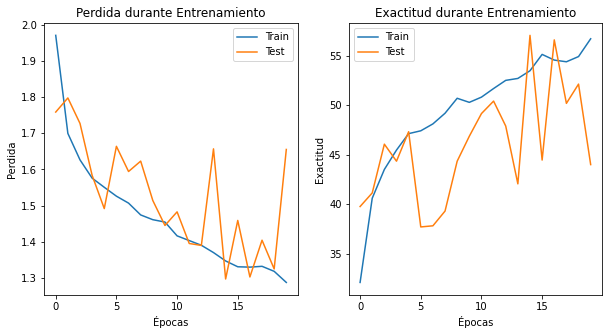

In [20]:
# Reproducibilidad: dejamos el estado de las semillas de aleatoriedad fijo
# en cada ejecución
torch.random.set_rng_state(state_torch)
torch.cuda.random.set_rng_state(state_torch_cuda)
np.random.set_state(state_np)
# Parametros para crear nuestros datasets a partir de los folds establecidos
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = './UrbanSound8K/audio/'
train_folds = [2,3,4,5,6,7,8,9,10]          # Entrenamos con folds 2-10
test_folds = [1]                            # Testeamos con el fold n°1
train_set = AudioDataset(csv_path, file_path, train_folds)
test_set = AudioDataset(csv_path, file_path, test_folds)
# Estos son parámetros para optimizar un poco la velocidad, no son críticos.
kwargs = {'num_workers': 0} if device == 'cuda' else {} 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, **kwargs)

# Creamos el modelo
net = M3()
net = net.to(device)
net.apply(init_weights) # Inicializamos los pesos de nuestra red con método Xavier

# Pérdida usual de Clasificación
criterion = nn.CrossEntropyLoss()
# Optimizador: Adam, no innovaremos.
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.0001)
# Opcional: el scheduler se encarga de cambiar el learning rate cada N épocas.
# Como está seteado ahora, el cambio sucede cada 20 épocas y multiplica 
# la tasa de aprendizaje por 0.1, es decir, la divide por 10.
# En la época 41 la reduciría de nuevo.
# Para las actividades que vamos a ocupar no importa, pero si desean entrenar
# por más épocas puede serles útil.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

# Métricas
# Guardamos la pérdida y la exactitud
loss_epoch_train = []
loss_epoch_test = []
accuracy_epoch_train = []
accuracy_epoch_test = []

# Loop de entrenamiento
n_epochs = 20
best_accuracy = 0.0
best_model = net

for epoch in range(n_epochs):
    accuracy_train, losses_train = train(net, epoch) # 1 época de entrenamiento
    scheduler.step() # Relacionado al Scheduler opcional, si se ocupa, se debe
                     # Hacer step después del fin de cada época
    loss_epoch_train.append(losses_train)         # Actualizamos métricas
    accuracy_epoch_train.append(accuracy_train)
    accuracy_test, losses_test, test_preds, test_gts = test(net, epoch) # Probamos en test cómo vamos
    loss_epoch_test.append(losses_test)           # Actualizamos métricas
    if accuracy_test > best_accuracy:             # Guardamos resultados del mejor modelo
        best_model = net
        best_accuracy = accuracy_test
        best_preds = test_preds
        best_gt = test_gts
    accuracy_epoch_test.append(accuracy_test)
    print('Epoca {} Completa - Exactitud Train: {:.2f}% - Exactitud Test: {:.2f}%'.format(epoch+1,accuracy_train, accuracy_test))

# Graficar resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = plot_results(ax[0],loss_epoch_train, loss_epoch_test, label_metrica="Perdida")
ax[1] = plot_results(ax[1],accuracy_epoch_train, accuracy_epoch_test, label_metrica="Exactitud")
fig.savefig('figure_fold:{0}_model:{1}.png'.format(1, "M3"))

**RESPUESTA** La maxima exactitud del entrenamiento es de 56.70%, en la ultima epoca. Para la misma epoca, la exactitud del test es de 43.99%.

Esto es bastante menos que la maxima exactitud del test de 57% en la epoca 15. El aumento en exactitud del training y disminucion del test puede indicar overfitting.

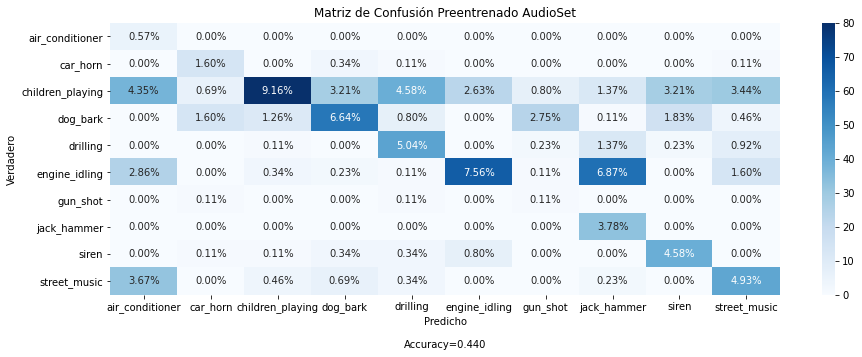

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
clases = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jack_hammer','siren','street_music']
cf = confusion_matrix(test_preds.cpu(), test_gts.cpu())
make_confusion_matrix(cf, categories=clases, count=False,figsize=(15,5),title="Matriz de Confusión Preentrenado AudioSet")

In [22]:
result = classification_report(test_gts.cpu(), test_preds.cpu(), labels=None, target_names=clases, digits=2, zero_division='warn')
print(result)

                  precision    recall  f1-score   support

 air_conditioner       1.00      0.05      0.10       100
        car_horn       0.74      0.39      0.51        36
children_playing       0.27      0.80      0.41       100
        dog_bark       0.43      0.58      0.49       100
        drilling       0.64      0.44      0.52       100
   engine_idling       0.38      0.69      0.49        96
        gun_shot       0.33      0.03      0.05        35
     jack_hammer       1.00      0.28      0.43       120
           siren       0.73      0.47      0.57        86
    street_music       0.48      0.43      0.45       100

        accuracy                           0.44       873
       macro avg       0.60      0.41      0.40       873
    weighted avg       0.62      0.44      0.42       873



### Actividad 4 (Opcional, No Evaluada):

Entre el modelo con M18 por 20 épocas. ¿Cuál es su rendimiento máximo en test? ¿Cuál era su rendimiento en training para esa época? Grafique la matriz de confusión y obtenga el precision y recall de cada clase. *Recuerde copiar y pegar su código acá, **si no, no será evaluado**.*

Epoca Entrenamiento: 0 [8640/8732 (99%)]	Loss: 2.038613
Epoca 1 Completa - Exactitud Train: 19.41% - Exactitud Test: 15.01%
Epoca Entrenamiento: 1 [8640/8732 (99%)]	Loss: 2.211162
Epoca 2 Completa - Exactitud Train: 25.54% - Exactitud Test: 17.98%
Epoca Entrenamiento: 2 [8640/8732 (99%)]	Loss: 1.768319
Epoca 3 Completa - Exactitud Train: 28.72% - Exactitud Test: 29.21%
Epoca Entrenamiento: 3 [8640/8732 (99%)]	Loss: 2.124350
Epoca 4 Completa - Exactitud Train: 36.34% - Exactitud Test: 33.56%
Epoca Entrenamiento: 4 [8640/8732 (99%)]	Loss: 1.698060
Epoca 5 Completa - Exactitud Train: 38.55% - Exactitud Test: 31.16%
Epoca Entrenamiento: 5 [8640/8732 (99%)]	Loss: 1.609238
Epoca 6 Completa - Exactitud Train: 41.50% - Exactitud Test: 23.83%
Epoca Entrenamiento: 6 [8640/8732 (99%)]	Loss: 1.418001
Epoca 7 Completa - Exactitud Train: 44.06% - Exactitud Test: 23.60%
Epoca Entrenamiento: 7 [8640/8732 (99%)]	Loss: 2.323295
Epoca 8 Completa - Exactitud Train: 45.76% - Exactitud Test: 34.59%
Epoca En

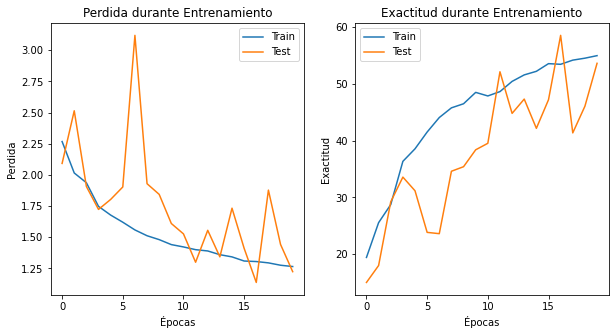

In [23]:
# Reproducibilidad: dejamos el estado de las semillas de aleatoriedad fijo
# en cada ejecución
torch.random.set_rng_state(state_torch)
torch.cuda.random.set_rng_state(state_torch_cuda)
np.random.set_state(state_np)
# Parametros para crear nuestros datasets a partir de los folds establecidos
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = './UrbanSound8K/audio/'
train_folds = [2,3,4,5,6,7,8,9,10]          # Entrenamos con folds 2-10
test_folds = [1]                            # Testeamos con el fold n°1
train_set = AudioDataset(csv_path, file_path, train_folds)
test_set = AudioDataset(csv_path, file_path, test_folds)
# Estos son parámetros para optimizar un poco la velocidad, no son críticos.
kwargs = {'num_workers': 0} if device == 'cuda' else {} 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, **kwargs)

# Creamos el modelo
net = M18()
net = net.to(device)
net.apply(init_weights) # Inicializamos los pesos de nuestra red con método Xavier

# Pérdida usual de Clasificación
criterion = nn.CrossEntropyLoss()
# Optimizador: Adam, no innovaremos.
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.0001)
# Opcional: el scheduler se encarga de cambiar el learning rate cada N épocas.
# Como está seteado ahora, el cambio sucede cada 20 épocas y multiplica 
# la tasa de aprendizaje por 0.1, es decir, la divide por 10.
# En la época 41 la reduciría de nuevo.
# Para las actividades que vamos a ocupar no importa, pero si desean entrenar
# por más épocas puede serles útil.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

# Métricas
# Guardamos la pérdida y la exactitud
loss_epoch_train = []
loss_epoch_test = []
accuracy_epoch_train = []
accuracy_epoch_test = []

# Loop de entrenamiento
n_epochs = 20
best_accuracy = 0.0
best_model = net

for epoch in range(n_epochs):
    accuracy_train, losses_train = train(net, epoch) # 1 época de entrenamiento
    scheduler.step() # Relacionado al Scheduler opcional, si se ocupa, se debe
                     # Hacer step después del fin de cada época
    loss_epoch_train.append(losses_train)         # Actualizamos métricas
    accuracy_epoch_train.append(accuracy_train)
    accuracy_test, losses_test, test_preds, test_gts = test(net, epoch) # Probamos en test cómo vamos
    loss_epoch_test.append(losses_test)           # Actualizamos métricas
    if accuracy_test > best_accuracy:             # Guardamos resultados del mejor modelo
        best_model = net
        best_accuracy = accuracy_test
        best_preds = test_preds
        best_gt = test_gts
    accuracy_epoch_test.append(accuracy_test)
    print('Epoca {} Completa - Exactitud Train: {:.2f}% - Exactitud Test: {:.2f}%'.format(epoch+1,accuracy_train, accuracy_test))

# Graficar resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = plot_results(ax[0],loss_epoch_train, loss_epoch_test, label_metrica="Perdida")
ax[1] = plot_results(ax[1],accuracy_epoch_train, accuracy_epoch_test, label_metrica="Exactitud")
fig.savefig('figure_fold:{0}_model:{1}.png'.format(1, "M3"))

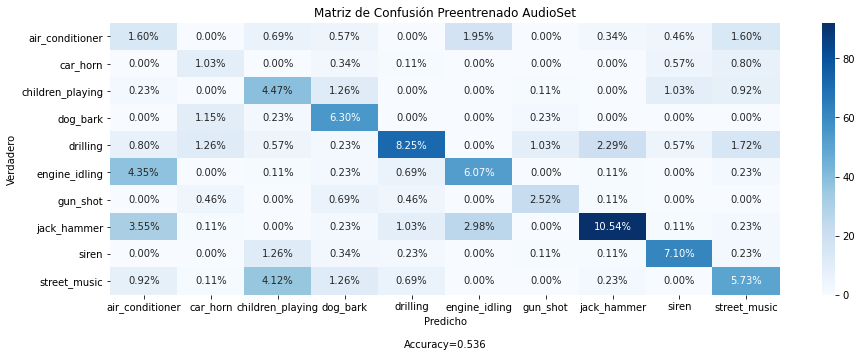

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
clases = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jack_hammer','siren','street_music']
cf = confusion_matrix(test_preds.cpu(), test_gts.cpu())
make_confusion_matrix(cf, categories=clases, count=False,figsize=(15,5),title="Matriz de Confusión Preentrenado AudioSet")

In [25]:
result = classification_report(test_gts.cpu(), test_preds.cpu(), labels=None, target_names=clases, digits=2, zero_division='warn')
print(result)

                  precision    recall  f1-score   support

 air_conditioner       0.22      0.14      0.17       100
        car_horn       0.36      0.25      0.30        36
children_playing       0.56      0.39      0.46       100
        dog_bark       0.80      0.55      0.65       100
        drilling       0.49      0.72      0.59       100
   engine_idling       0.51      0.55      0.53        96
        gun_shot       0.59      0.63      0.61        35
     jack_hammer       0.56      0.77      0.65       120
           siren       0.76      0.72      0.74        86
    street_music       0.44      0.50      0.47       100

        accuracy                           0.54       873
       macro avg       0.53      0.52      0.52       873
    weighted avg       0.53      0.54      0.52       873



### Actividad 5 (Opcional, No Evaluada):

¿Nota alguna diferencia en el aprendizaje entre el modelo M3 y M18 durante el entrenamiento? Mencione al menos dos diferencias.

El modelo M18 parece ser menos caotico o irregular en el loss y exactitud que el M3, y logra una mejor exactitud que el M3

### Actividad 6 (Opcional, No Evaluada):
Si es que hay una diferencia, ¿por qué cree que se da la diferencia anterior? En el caso de que no la haya, ¿por qué cree que no hay diferencia?

Al tener más capas, es posible que aprenda más atributos de las señales de audio

## Parte 2: Modelo Preentrenado en AudioSet

En esta sección atacaremos el mismo problema anterior, pero con un modelo preentrenado en AudioSet, uno de los datasets que vimos la clase pasada. Para esto, ocuparemos el modelo VGGish (https://arxiv.org/pdf/1610.00087.pdf), modelo como cuyo nombre indica es similar en estructura al modelo VGG que usamos en imágenes. 

Este modelo en particular fue preentrenado en el dataset AudioSet (https://research.google.com/audioset/), que como les comentamos la clase anterior, puede ser considerado una especie de ImageNet para sonidos ambientales.

A continuación, haremos finetuning de este modelo por una época en nuestro dataset UrbanSound8K y veremos qué tal anda.

*Modelo Preentrenado tomado de:* https://github.com/tcvrick/audioset-vggish-tensorflow-to-pytorch


### Definición Modelo VGGish

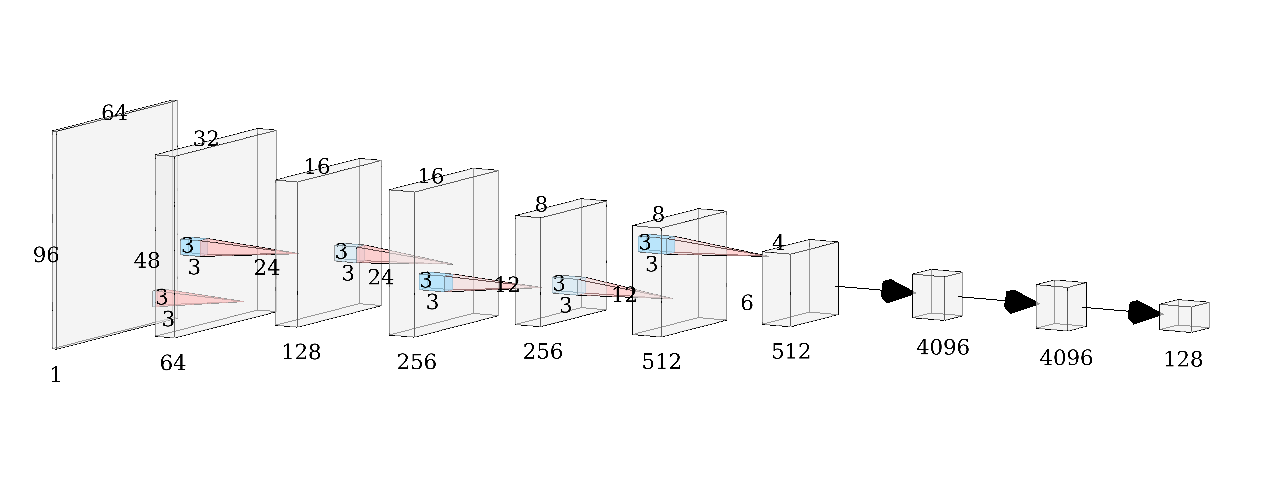

*Diagrama creado con:* http://alexlenail.me/NN-SVG/AlexNet.html

In [2]:
import torch.nn as nn
import torch

class VGGish(nn.Module):
    """
    PyTorch implementation of the VGGish model.

    Adapted from: https://github.com/harritaylor/torch-vggish
    The following modifications were made: (i) correction for the missing ReLU layers, (ii) correction for the
    improperly formatted data when transitioning from NHWC --> NCHW in the fully-connected layers, and (iii)
    correction for flattening in the fully-connected layers.
    """

    def __init__(self):
        super(VGGish, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 24, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 128),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.features(x).permute(0, 2, 3, 1).contiguous()
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


Este modelo es bastante más pesado que los modelos M que vimos en la parte anterior en términos de parámetros. Principalmente, esto sucede por la sección final Fully Connected. ¡Ésta acumula por sí sola más de 60 millones de parámetros! Por esto, es esta sección no entrenaremos por más de 2 épocas el modelo. 

Otra cosa más importante es que si nos damos cuenta en este modelo estamos ocupando Convoluciones 2D en vez de Convoluciones 1D. Esto es porque este modelo trabaja con features MFCC en vez del audio puro. Además, el modelo está pensado para recibir alrededor de 1 segundo de audio como entrada.

Dados todos estos cambios, ¿cómo pódemos utilizarlo para nuestro dataset anterior?

Tenemos que hacer algunos ajustes:
* Modificaremos la clase AudioDataset para que nos entregue features MFCC. Dividiremos cada sample en 3 audios de 1 segundo cada uno.
* Tendremos que modificar cómo construimos nuestros batches pues ahora tenemos 3 tensores de 1 segundo cada 1 versus 1 solo label. Tenemos que crear labels para cada tensor.

In [3]:
!git clone https://github.com/tcvrick/audioset-vggish-tensorflow-to-pytorch.git

fatal: destination path 'audioset-vggish-tensorflow-to-pytorch' already exists and is not an empty directory.


In [4]:
%cd audioset-vggish-tensorflow-to-pytorch/

/content/audioset-vggish-tensorflow-to-pytorch


### Descarga Pesos Modelo Preentrenado

In [ ]:
!wget https://github.com/tcvrick/audioset-vggish-tensorflow-to-pytorch/releases/download/v0.1/pytorch_vggish.zip -q --show-progress
!unzip pytorch_vggish.zip

pytorch_vggish.zip. 100%[===================>] 256.11M  71.8MB/s    in 3.6s    
Archive:  pytorch_vggish.zip
replace pytorch_vggish.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torch.nn as nn
import torch.optim as optim
from audioset import vggish_input

class AudioDataset(Dataset):
    """
    A rapper class for the UrbanSound8K dataset.
    """

    def __init__(self, file_path, audio_paths, folds):
        """
        Args:
            file_path(string): path to the audio csv file
            root_dir(string): directory with all the audio folds
            folds: integer corresponding to audio fold number or list of fold number if more than one fold is needed
        """
        self.audio_file = pd.read_csv(file_path)
        self.folds = folds
        self.audio_paths = glob.glob(audio_paths + '/*' + str(self.folds) + '/*')

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        
        audio_path = self.audio_paths[idx]
        audio, rate = torchaudio.load(audio_path, normalization=True)
        c, n = audio.shape
        audio = audio.mean(0)

        # Cambios para trabajar con VGGish
        zero_need = rate*3 - n  # Queremos 3 segundos de audio, si el audio es más corto, este número nos dice cuánto rellenar
        audio = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0) # Rellenamos con 0s
        audio = vggish_input.waveform_to_examples(audio.numpy(), rate) # Transformamos a MFCC --> 3 x 96 x 64
        # Fin cambios
        audio_name = audio_path.split(sep='/')[-1]
        labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
        
        return torch.from_numpy(audio), labels

In [ ]:
import time
def train(model, epoch, log_interval=10):
    model.train()
    correct = 0
    losses_train = []
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        data = data.requires_grad_() #set requires_grad to True for training
        output = model(data)
        loss = criterion(output, target) #the loss functions expects a batchSizex10 input
        losses_train.append(loss.item())
        pred = output.max(1)[1] 
        correct += pred.eq(target).cpu().sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0: #print training stats
            end_time = time.time()
            delta = end_time - start_time
            est_time = len(train_loader)/batch_idx*delta if batch_idx > 0 else 0
            print('\rEpoca Entrenamiento: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} - Time: {:.1f}s Est Time: {:.1f}s'.format(epoch+1, 
                                                                                                             batch_idx * len(data), 
                                                                                                             3*len(train_loader.dataset),  
                  100. * batch_idx / len(train_loader), loss, delta, est_time), end="")
    print("")
    return 100. * correct / (3*len(train_loader.dataset)), np.mean(losses_train)

def test(model, epoch):
    model.eval()
    correct = 0
    test_losses = []
    test_p = []
    test_gts = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(data)
            # Calculo métricas
            # Pérdida
            loss = criterion(output, target) #the loss functions expects a batchSizex10 input
            test_losses.append(loss.item())
            # Exactitud
            pred = output.max(1)[1]                         # Nos quedamos con el mayor valor del output
            test_p.append(pred)
            test_gts.append(target)
            correct += pred.eq(target).cpu().sum().item()   # Sumamos los ejemplos en que le apuntamos a la clase
        test_p = torch.cat(test_p, dim=0).long()
        test_gts = torch.cat(test_gts, dim=0).long()
    return 100. * correct / (3*len(test_loader.dataset)), np.mean(test_losses), test_p, test_gts

### Gráfico de Métricas

In [ ]:
import matplotlib.pyplot as plt
def plot_results(ax, m_train, m_test, label_metrica="Perdida"):
    n_epocas = len(m_train)
    ax.plot(np.arange(n_epocas), m_train, label = 'Train')
    ax.plot(np.arange(n_epocas), m_test, label = 'Test')
    ax.set_title('{} durante Entrenamiento'.format(label_metrica))
    ax.set_xlabel('Épocas')
    ax.set_ylabel(label_metrica)
    ax.legend()
    return ax

### Reproducibilidad: Correr esto sólo una vez

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
state_np = np.random.get_state()
state_torch = torch.random.get_rng_state()
state_torch_cuda = torch.cuda.random.get_rng_state()
torch.set_deterministic(False)
torch.backends.cudnn.benchmark = False

### Cambiar cómo armamos el batch

Si recuerdan bien, el laboratorio pasado aprendimos a cómo cambiar cómo estaba estructurado el batch para lidiar con el problema del largo variable de nuestros inputs. Esto lo hicimos usando lo que se llaman las *collate functions*. Éstas entran como parámetro del DataLoader que ocupemos en *collate_fn*. *make_batch* será la nueva *collate function* para nuestro DataLoader

In [ ]:
# make_batch se encarga de replicar los labels 3 veces 
# para que cada sample tenga su propio label
def make_batch(batch):
    tensors = []
    labels = []
    for tensor, label in batch:
        bs, *_ = tensor.shape
        tensors.append(tensor)
        for i in range(bs):
            labels.append(label)
    tensors = torch.cat(tensors, dim=0).float()
    
    return tensors.unsqueeze(1), torch.tensor(labels).long()

### Hacer Finetuning del modelo (1 hora y media)

In [ ]:
# Reproducibilidad: dejamos el estado de las semillas de aleatoriedad fijo
# en cada ejecución
torch.random.set_rng_state(state_torch)
torch.cuda.random.set_rng_state(state_torch_cuda)
np.random.set_state(state_np)
# Parametros para crear nuestros datasets a partir de los folds establecidos
csv_path = '../UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = '../UrbanSound8K/audio/'
train_folds = [2,3,4,5,6,7,8,9,10]          # Entrenamos con folds 2-10
test_folds = [1]                            # Testeamos con el fold n°1
train_set = AudioDataset(csv_path, file_path, train_folds)
test_set = AudioDataset(csv_path, file_path, test_folds)
# Estos son parámetros para optimizar un poco la velocidad, no son críticos.
kwargs = {'num_workers': 0, 'pin_memory': True} if device == 'cuda' else {} 
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size = 32,
                                           collate_fn=make_batch, 
                                           shuffle = True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size = 32,
                                          collate_fn=make_batch,
                                          shuffle = False,
                                          **kwargs)

# Creamos el modelo
net = VGGish()          
net.load_state_dict(torch.load('./pytorch_vggish.pth'))
for param in net.parameters():
    param.requires_grad = False
# Reemplazamos la última capa lineal por una capa de 10.
net.fc[-2] = nn.Linear(in_features=4096, out_features=10, bias=True)
net = net.to(device)

# Pérdida usual de Clasificación
criterion = nn.CrossEntropyLoss()
# Optimizador: Adam, no innovaremos.
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.0001)

# Métricas
# Guardamos la pérdida y la exactitud
loss_epoch_train = []
loss_epoch_test = []
accuracy_epoch_train = []
accuracy_epoch_test = []

# Loop de entrenamiento
n_epochs = 3
for epoch in range(n_epochs):
    accuracy_train, losses_train = train(net, epoch) # 1 época de entrenamiento
    loss_epoch_train.append(losses_train)         # Actualizamos métricas
    accuracy_epoch_train.append(accuracy_train)
    accuracy_test, losses_test, test_preds, test_gts = test(net, epoch) # Probamos en test cómo vamos
    loss_epoch_test.append(losses_test)           # Actualizamos métricas
    accuracy_epoch_test.append(accuracy_test)
    print('Epoca {} Completa - Exactitud Train: {:.2f}% - Exactitud Test: {:.2f}%'.format(epoch+1,accuracy_train, accuracy_test))


### Matriz de Confusión

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
clases = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jack_hammer','siren','street_music']
cf = confusion_matrix(test_gts.cpu(), test_preds.cpu())
make_confusion_matrix(cf, categories=clases, count=False,figsize=(15,5),title="Matriz de Confusión Preentrenado AudioSet")

### Reporte Precision-Recall y F1

Este reporte nos permite entender de mejor manera lo que está sucediendo con la predicción de cada una de las clases, quizás dándonos indicios de qué clases nos traen más problemas y por qué.

In [ ]:
from IPython.display import display, Markdown, Latex

result = classification_report(test_gts.cpu(), test_preds.cpu(), labels=None, target_names=clases, digits=2, zero_division=0)
print(result)

### Resultados

Vemos que con un modelo preentrenado, en la primera época de entrenamiento ya tenemos un modelo competitivo con haber entrenado desde 0. Más encima, esta capacidad viene con solo entrenar a partir de 1 segundo de audio, por lo que al hacer la agregación por 3 debería ser aún mejor.